# Download Package Needed

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Embed the heads and tails in ATOMIC2020 dataset

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image




model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


tqdm.pandas()

def get_text_embeddings_with_stopwords(text_list, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(text_list), batch_size)):
        batch_texts = text_list[i:i+batch_size]

        # Use the original text directly without removing stopwords or tokenizing
        inputs = processor(text=batch_texts, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            text_features = model.get_text_features(**inputs)
        # Do not normalize embeddings
        text_features = text_features.cpu().numpy()
        embeddings.append(text_features)
    embeddings = np.vstack(embeddings)
    return embeddings

# Load data
train_file_path = '/content/drive/MyDrive/Commonsense_Retrieval/train.tsv'
dev_file_path = '/content/drive/MyDrive/Commonsense_Retrieval/dev.tsv'
test_file_path = '/content/drive/MyDrive/Commonsense_Retrieval/test.tsv'

train_atomic_data = pd.read_csv(train_file_path, sep='\t', header=None)
dev_atomic_data = pd.read_csv(dev_file_path, sep='\t', header=None)
test_atomic_data = pd.read_csv(test_file_path, sep='\t', header=None)

atomic_data = pd.concat([train_atomic_data, dev_atomic_data, test_atomic_data], ignore_index=True)

# Extract heads and tails
heads = atomic_data[0].astype(str).tolist()
tails = atomic_data[2].astype(str).tolist()

# Get embeddings for heads and tails without removing stopwords
print("Embedding heads...")
heads_embeddings = get_text_embeddings_with_stopwords(heads, batch_size=3096)
print(f"Heads embeddings shape: {heads_embeddings.shape}")

print("Embedding tails...")
tails_embeddings = get_text_embeddings_with_stopwords(tails, batch_size=4096)
print(f"Tails embeddings shape: {tails_embeddings.shape}")

# Save embeddings as pickle files
with open('/content/drive/MyDrive/Commonsense_Retrieval/heads_embeddings_with_stopwords.pkl', 'wb') as f:
    pickle.dump(heads_embeddings, f)

with open('/content/drive/MyDrive/Commonsense_Retrieval/tails_embeddings_with_stopwords.pkl', 'wb') as f:
    pickle.dump(tails_embeddings, f)

print("Embeddings with stopwords have been saved to 'heads_embeddings_with_stopwords.pkl' and 'tails_embeddings_with_stopwords.pkl'.")

# Define the Commonsense categories and get image and text embedding.

In [ ]:
# Define relation categories based on provided structure
CS_PE_relations = ["ObjectUse", "AtLocation", "MadeUpOf", "HasProperty", "CapableOf", "Desires", "Not Desires"]
CS_EC_relations = ["IsAfter", "HasSubEvent", "IsBefore", "HinderedBy", "Causes", "xReason", "isFilledBy"]
CS_SI_relations = ["xNeed", "xAttr", "xEffect", "xReact", "xWant", "xIntent", "oEffect", "oReact", "oWant"]

def retrieve_top_commonsense_triplets_by_category(embedding, head_embeddings, tail_embeddings, top_k=10, candidate_k=500, metric='cosine'):
    if not isinstance(embedding, torch.Tensor):
        embedding = torch.tensor(embedding)
    if not isinstance(head_embeddings, torch.Tensor):
        head_embeddings = torch.tensor(head_embeddings)
    if not isinstance(tail_embeddings, torch.Tensor):
        tail_embeddings = torch.tensor(tail_embeddings)

    # Normalize embeddings if using cosine similarity
    if metric == 'cosine':
        embedding_norm = embedding.norm(p=2)
        head_norms = head_embeddings.norm(p=2, dim=1)
        tail_norms = tail_embeddings.norm(p=2, dim=1)

        embedding = embedding.view(-1, 1)  # Ensure correct shape for matmul
        similarities_head = torch.matmul(head_embeddings, embedding).squeeze() / (head_norms * embedding_norm)
        similarities_tail = torch.matmul(tail_embeddings, embedding).squeeze() / (tail_norms * embedding_norm)
        similarities = torch.cat([similarities_head, similarities_tail])
        # Retrieve the most similar triples by highest similarity
        top_similarities, top_indices = torch.topk(similarities, candidate_k)
    else:
        # Reshape embedding for broadcasting in Euclidean/Manhattan
        embedding = embedding.view(1, -1)
        if metric == 'euclidean':
            distances_head = torch.cdist(head_embeddings, embedding, p=2).squeeze()
            distances_tail = torch.cdist(tail_embeddings, embedding, p=2).squeeze()
        elif metric == 'manhattan':
            distances_head = torch.cdist(head_embeddings, embedding, p=1).squeeze()
            distances_tail = torch.cdist(tail_embeddings, embedding, p=1).squeeze()

        distances = torch.cat([distances_head, distances_tail])
        # Retrieve the most similar triples by lowest distance
        top_distances, top_indices = torch.topk(-distances, candidate_k)
        # Convert distances to positive values for printing
        top_similarities = -top_distances

    total_head = head_embeddings.size(0)
    results_by_category = {"CS-PE": [], "CS-EC": [], "CS-SI": []}

    # Categorize the top `candidate_k` triples into CS-PE, CS-EC, and CS-SI
    for idx, sim in zip(top_indices, top_similarities):
        idx = idx.item()
        sim = sim.item()
        if idx < total_head:
            source = 'head'
            original_idx = idx
        else:
            source = 'tail'
            original_idx = idx - total_head

        relation = relations[original_idx]
        triplet = (source, original_idx, sim, heads[original_idx], relation, tails[original_idx])

        if relation in CS_PE_relations and len(results_by_category["CS-PE"]) < top_k:
            results_by_category["CS-PE"].append(triplet)
        elif relation in CS_EC_relations and len(results_by_category["CS-EC"]) < top_k:
            results_by_category["CS-EC"].append(triplet)
        elif relation in CS_SI_relations and len(results_by_category["CS-SI"]) < top_k:
            results_by_category["CS-SI"].append(triplet)

        if all(len(results_by_category[cat]) >= top_k for cat in results_by_category):
            break

    return results_by_category

def get_image_embedding(image_path):
    image = Image.open(image_path)
    inputs = processor(images=image, return_tensors="pt")
    if torch.cuda.is_available():
        model.to('cuda')
        inputs = {k: v.to('cuda') for k, v in inputs.items()}
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    # Removed normalization
    return image_features.cpu().numpy()

In [ ]:
train_file_path = '/content/drive/MyDrive/Commonsense_Retrieval/train.tsv'
dev_file_path = '/content/drive/MyDrive/Commonsense_Retrieval/dev.tsv'
test_file_path = '/content/drive/MyDrive/Commonsense_Retrieval/test.tsv'

train_atomic_data = pd.read_csv(train_file_path, sep='\t', header = None)
dev_atomic_data = pd.read_csv(dev_file_path, sep='\t', header = None)
test_atomic_data = pd.read_csv(test_file_path, sep='\t', header = None)

atomic_data = pd.concat([train_atomic_data, dev_atomic_data, test_atomic_data], ignore_index = True)
# atomic_data = pd.concat([dev_atomic_data, test_atomic_data], ignore_index = True)
print(atomic_data.head())
print()
heads = atomic_data[0].tolist()
tails = atomic_data[2].tolist()
tails = [tail if type(tail) ==str else 'none'  for tail in tails]
relations = atomic_data[1].tolist()
print(len(heads))
print(len(tails))
print(len(relations))

                                 0        1         2
0  PersonX abandons ___ altogether  oEffect      none
1  PersonX abandons ___ altogether  oEffect      none
2  PersonX abandons ___ altogether   oReact  dejected
3  PersonX abandons ___ altogether    oWant      none
4  PersonX abandons ___ altogether    oWant      none

1331113
1331113
1331113


# Image Commonsense Retrieval

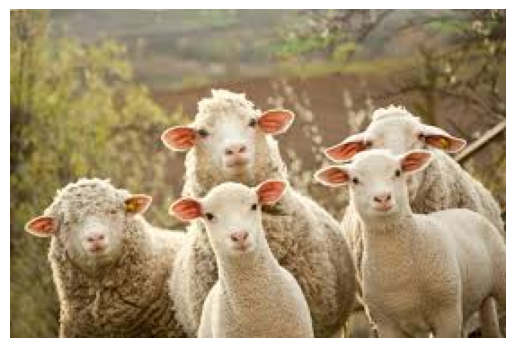


Results for Cosine Distance

Category: CS-PE
Source: tail, Distance/Similarity: 0.3055, Phrase: canine --- ObjectUse --- herd sheep
Source: tail, Distance/Similarity: 0.2986, Phrase: undergarments --- ObjectUse --- keep skin away from wool
Source: tail, Distance/Similarity: 0.2984, Phrase: shepard --- CapableOf --- lead sheep to better pastures
Source: head, Distance/Similarity: 0.2966, Phrase: herd of sheep --- AtLocation --- country
Source: tail, Distance/Similarity: 0.2956, Phrase: shepherd --- CapableOf --- bell sheep
Source: tail, Distance/Similarity: 0.2906, Phrase: needles --- ObjectUse --- move the wool

Category: CS-EC
Source: tail, Distance/Similarity: 0.2962, Phrase: PersonX buys a sweater --- HinderedBy --- Are allergic to wool
Source: head, Distance/Similarity: 0.2951, Phrase: PersonX giveth PersonX's ___ for the sheep --- isFilledBy --- dogs
Source: head, Distance/Similarity: 0.2951, Phrase: PersonX giveth PersonX's ___ for the sheep --- isFilledBy --- life
Source: head,

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Retrieve image embedding
image_path = "/content/002.jpeg"
image_embedding = get_image_embedding(image_path)

# Retrieve top commonsense triples for each metric
metrics = ['cosine', 'euclidean', 'manhattan']
all_results = {}
for metric in metrics:
    categorized_results = retrieve_top_commonsense_triplets_by_category(image_embedding, heads_embeddings, tails_embeddings, top_k=6, candidate_k=3000, metric=metric)
    all_results[metric] = categorized_results


img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()


# Print categorized results for each metric
for metric, categorized_results in all_results.items():
    print(f"\nResults for {metric.capitalize()} Distance")
    for category, triples in categorized_results.items():
        print(f"\nCategory: {category}")
        for source, idx, sim, head, relation, tail in triples:
            phrase = f"{head} --- {relation} --- {tail}"
            print(f"Source: {source}, Distance/Similarity: {sim:.4f}, Phrase: {phrase}")



In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Set up stopwords
stop_words = set(stopwords.words('english'))
stop_words.update(["PersonX", "PersonY", "PersonX's", "PersonY's", "___"])



def get_text_embedding_with_stopwords(text):
    # Remove stopwords from text
    filtered_text = text
    inputs = processor(text=[filtered_text], return_tensors="pt", padding=True)
    if torch.cuda.is_available():
        model.to('cuda')
        inputs = {k: v.to('cuda') for k, v in inputs.items()}
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    # Removed normalization
    return text_features.cpu().numpy()


def get_text_embedding_without_stopwords(text):
    # Remove stopwords from text
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)

    inputs = processor(text=[filtered_text], return_tensors="pt", padding=True)
    if torch.cuda.is_available():
        model.to('cuda')
        inputs = {k: v.to('cuda') for k, v in inputs.items()}
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)
    # Removed normalization
    return text_features.cpu().numpy()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
text = "There are many sheep"

text_embedding = get_text_embedding_without_stopwords(text)
metrics = ['cosine', 'euclidean', 'manhattan']
all_results = {}
for metric in metrics:
    categorized_results = retrieve_top_commonsense_triplets_by_category(text_embedding, heads_embeddings, tails_embeddings, top_k=5, candidate_k=3000, metric=metric)
    all_results[metric] = categorized_results

# Print categorized results for each metric
for metric, categorized_results in all_results.items():
    print(f"\nResults for {metric.capitalize()} Distance")
    for category, triples in categorized_results.items():
        print(f"\nCategory: {category}")
        for source, idx, sim, head, relation, tail in triples:
            phrase = f"{head} --- {relation} --- {tail}"
            print(f"Source: {source}, Distance/Similarity: {sim:.4f}, Phrase: {phrase}")



Results for Cosine Distance

Category: CS-PE
Source: head, Distance/Similarity: 0.9386, Phrase: sheep --- MadeUpOf --- trotter
Source: head, Distance/Similarity: 0.9386, Phrase: sheep --- AtLocation --- farm
Source: tail, Distance/Similarity: 0.9386, Phrase: wool --- AtLocation --- sheep
Source: head, Distance/Similarity: 0.9386, Phrase: sheep --- HasProperty --- skilled at recognising faces
Source: head, Distance/Similarity: 0.9386, Phrase: sheep --- AtLocation --- fairgrounds

Category: CS-EC
Source: tail, Distance/Similarity: 0.9386, Phrase: PersonX protects ___ from abuse --- isFilledBy --- sheep
Source: tail, Distance/Similarity: 0.9386, Phrase: PersonX separates the ___ from the goats --- isFilledBy --- sheep
Source: tail, Distance/Similarity: 0.9386, Phrase: PersonX attacks another ___ --- isFilledBy --- sheep
Source: tail, Distance/Similarity: 0.9386, Phrase: PersonX gathers ___ together --- isFilledBy --- sheep
Source: tail, Distance/Similarity: 0.9386, Phrase: PersonX brings

# Relevance Score Assignment

In [ ]:

# Function to calculate mean and standard deviation
def calculate_statistics(data):
    stats = {}
    for metric, categories in data.items():
        values = []
        for category, tuples in categories.items():
            # Extract the numerical values (index 2 in each tuple)
            values.extend([t[2] for t in tuples])
        # Calculate mean and standard deviation
        mean = np.mean(values)
        std_dev = np.std(values)
        stats[metric] = {"mean": mean, "std_dev": std_dev}
    return stats

statistics = calculate_statistics(all_results)

# Display results
for metric, stats in statistics.items():
    print(f"{metric.capitalize()} - Mean: {stats['mean']:.4f}, Standard Deviation: {stats['std_dev']:.4f}")

Cosine - Mean: 0.9301, Standard Deviation: 0.0122
Euclidean - Mean: 3.7260, Standard Deviation: 0.2967
Manhattan - Mean: 64.9935, Standard Deviation: 5.2281
